# Guide to Network Analysis (Part 2 - Find Routes)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li><li><span><a href="#Problem-statement" data-toc-modified-id="Problem-statement-2">Problem statement</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3">Data</a></span><ul class="toc-item"><li><span><a href="#Use-existing-feature-service-for-Stops-Feature-Class" data-toc-modified-id="Use-existing-feature-service-for-Stops-Feature-Class-3.1">Use existing feature service for Stops Feature Class</a></span></li><li><span><a href="#Re-arrange-the-order-of-stops" data-toc-modified-id="Re-arrange-the-order-of-stops-3.2">Re-arrange the order of stops</a></span></li></ul></li><li><span><a href="#Methods" data-toc-modified-id="Methods-4">Methods</a></span><ul class="toc-item"><li><span><a href="#Method-1---Using-arcgis.network.RouteLayer.solve" data-toc-modified-id="Method-1---Using-arcgis.network.RouteLayer.solve-4.1">Method 1 - Using arcgis.network.RouteLayer.solve</a></span><ul class="toc-item"><li><span><a href="#What-is-a-Route-Analysis-Layer?" data-toc-modified-id="What-is-a-Route-Analysis-Layer?-4.1.1">What is a Route Analysis Layer?</a></span></li><li><span><a href="#Creating-Route-Layer" data-toc-modified-id="Creating-Route-Layer-4.1.2">Creating Route Layer</a></span></li><li><span><a href="#Calling-arcgis.network.RouteLayer.solve()" data-toc-modified-id="Calling-arcgis.network.RouteLayer.solve()-4.1.3">Calling arcgis.network.RouteLayer.solve()</a></span></li><li><span><a href="#Tabularizing-the-response-from-arcgis.network.RouteLayer.solve()" data-toc-modified-id="Tabularizing-the-response-from-arcgis.network.RouteLayer.solve()-4.1.4">Tabularizing the response from arcgis.network.RouteLayer.solve()</a></span></li><li><span><a href="#Visualizing-the-response-from-arcgis.network.RouteLayer.solve()" data-toc-modified-id="Visualizing-the-response-from-arcgis.network.RouteLayer.solve()-4.1.5">Visualizing the response from arcgis.network.RouteLayer.solve()</a></span></li></ul></li><li><span><a href="#Method-2---Using-arcgis.network.analysis.find_routes" data-toc-modified-id="Method-2---Using-arcgis.network.analysis.find_routes-4.2">Method 2 - Using arcgis.network.analysis.find_routes</a></span><ul class="toc-item"><li><span><a href="#Tabularizing-the-response-from-find_routes" data-toc-modified-id="Tabularizing-the-response-from-find_routes-4.2.1">Tabularizing the response from find_routes</a></span></li><li><span><a href="#Visualizing-the-response-from-find_routes" data-toc-modified-id="Visualizing-the-response-from-find_routes-4.2.2">Visualizing the response from find_routes</a></span></li><li><span><a href="#Comparing-method-2's-find_routes-to-method-1's-RouteLayer.solve" data-toc-modified-id="Comparing-method-2's-find_routes-to-method-1's-RouteLayer.solve-4.2.3">Comparing method 2's find_routes to method 1's RouteLayer.solve</a></span></li></ul></li><li><span><a href="#Method-3---Using-arcgis.features.use_proximity.plan_routes" data-toc-modified-id="Method-3---Using-arcgis.features.use_proximity.plan_routes-4.3">Method 3 - Using arcgis.features.use_proximity.plan_routes</a></span><ul class="toc-item"><li><span><a href="#With-output_name-specified" data-toc-modified-id="With-output_name-specified-4.3.1">With output_name specified</a></span></li><li><span><a href="#Without-output_name-specified" data-toc-modified-id="Without-output_name-specified-4.3.2">Without output_name specified</a></span></li></ul></li></ul></li></ul></div>

## Introduction

Now we have learned the concepts of Network Datasets and Network Analysis Layer (NA Layer), let's move on the second topic - how to find routes from one point to another, and among multiple points. This would solve questions like, "what is the quickest route from point A to point B", or "to travel among points [A, B, C, D, ...], what's the shorted route"? Please refer to the road map below if you want to revisit the previous topic or jump to the next topic. 

 - Network Dataset and Network Analysis Layer (<a href="guide_to_network_analysis_part1.ipynb">Part 1</a>) 
 - Find Routes (You are here!)
 - Generate Service Area (<a href="guide_to_network_analysis_part3.ipynb">Part 3</a>)
 - Find Closest Facility (<a href="guide_to_network_analysis_part4.ipynb">Part 4</a>)
 - Generate Origin Destination Cost Matrix (Part 5)
 - Solve Location Allocation (Part 6)
 - Vehicle Routing Problem Service (Part 7)
 - 3D Network Analysis Workflow (Part 8)

Routes represent the quickest or shortest path along roads to visit stops or point locations. They can be basic point-to-point routes visited in the order you specify, or in the order that minimizes overall travel time or distance. A route is associated with a local network dataset or a network service hosted in ArcGIS Online or ArcGIS Enterprise <a href="#References">[1]</a>. Here, we will show how to use the online service to solve these problems, e.g.

 - What is the quickest way to get from Manhattan to Brooklyn?
 - What are live or historical traffic conditions like, and how do they affect my network analysis results?

## Problem statement

The goal of part 2 is to show how to find routes among multiple points. Let's assume the user story is like this:

Jim is planning his Summer trip along the west of the States, and he has decided to start from Miami, end at San Francisco, and also make stops in eight other cities: San Jose, Los Angeles, San Diego, Phoenix, El Paso, Houston, New Orleans, Orlando. What will be the best route for Jim to travel between these ten cities without making extra stops? And what will be the estimated travel distance and time? Lastly, can Jim be provided with directions and maps for routing?

Now that Jim's objectives are defined, we can go onto break down the problem:
 - Data: where to access the input dataset
 - Methods: what tools can be used to build the network model and perform routing analysis
 - Tables and maps: deliverables in which directions and routes are visualized.
 
Let's first access and/or explore the input dataset (in this case, the stops feature class).

## Data

### Use existing feature service for Stops Feature Class

In order to construct the `stops feature class`, which is a Required parameter for the `find_routes` operation, you need to specify two or more stops to route between. You can add up to 10,000 stops and assign up to 150 stops to a single route.

In [1]:
from copy import deepcopy
from datetime import datetime
from IPython.display import HTML
import json
import pandas as pd
from arcgis.gis import GIS
import arcgis.network as network
import arcgis.geocoding as geocoding
from arcgis.features import FeatureLayer, FeatureSet, FeatureCollection
import arcgis.features.use_proximity as use_proximity

In [2]:
my_gis = GIS('https://www.arcgis.com', 'arcgis_python', 'P@ssword123')

<Item title:"USA Major Cities" type:Feature Layer Collection owner:esri_dm>
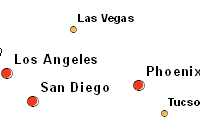

In [3]:
sample_cities = my_gis.content.search('title:"USA Major Cities" type:Feature Service owner:esri*', 
                                      outside_org=True)[0]
sample_cities

In [4]:
stops_cities = ['San Francisco', 'San Jose', 'Los Angeles', 'San Diego',
                'Phoenix', 'El Paso', 
                'Houston', 'New Orleans', 'Orlando', 'Miami']
values = "'" + "', '".join(stops_cities) + "'"

In [5]:
stops_cities_fl = FeatureLayer(sample_cities.url + "/0")
type(stops_cities_fl)

arcgis.features.layer.FeatureLayer

In [6]:
stops_cities_fset = stops_cities_fl.query(where="ST in ('CA', 'NV', 'TX', 'AZ', 'LA', 'FL')  AND NAME IN ({0})".format(values), as_df=False)
stops_cities_fset

<FeatureSet> 10 features

In [7]:
start_cities_fset = stops_cities_fl.query(where="ST='FL' AND NAME = 'Miami'", as_df=False)
start_cities_fset

<FeatureSet> 1 features

### Re-arrange the order of stops

Sometimes features in the returned resulting FeatureSet from `FeatureLayer.query()` are not in the same sequential order of the search string. For example, the starting city in `stops_cities` is "San Francisico", but in the returned FeatureSet `stops_cities_fset`, "Los Angeles" appears to be the start. 

In [8]:
list(map(lambda x: x.attributes['NAME'], stops_cities_fset))

['Los Angeles',
 'San Diego',
 'San Francisco',
 'San Jose',
 'Phoenix',
 'New Orleans',
 'Miami',
 'Orlando',
 'El Paso',
 'Houston']

The method `re_order_stop_cities` can be used to re-order the stops in the FeatureSet to match the original starting/ending sequence.

In [9]:
""" Used to re-order the stops to the desired order
"""
def re_order_stop_cities(fset=stops_cities_fset, start_city = "Miami", end_city = "San Francisco"):
    
    stops_cities_flist = []
    last_city = None

    for ea in fset:
        if ea.attributes['NAME'] == start_city:
            stops_cities_flist.insert(0, ea)
        elif ea.attributes['NAME'] == end_city:
            last_city = ea
        else:
            stops_cities_flist.append(ea)
    stops_cities_flist.append(last_city)
 
    return FeatureSet(stops_cities_flist)

In [10]:
re_ordered_stops_cities_fset = re_order_stop_cities()
re_ordered_stops_cities_fset

<FeatureSet> 10 features

In [11]:
re_ordered_stops_cities = list(map(lambda x: x.attributes['NAME'], re_ordered_stops_cities_fset))

## Methods

The ArcGIS API for Python provides three ways to solve a routing problem, which as shown in the table below are namely, **RouteLayer.solve**, **find_routes**, and **plan_routes**.

| Operation       | NA Layer                                    | network.analysis       | features.use_proximity |
|-----------------|---------------------------------------------|------------------------|------------------------|
| Route           | **RouteLayer.solve**                        | **find_routes**        | **plan_routes**        |
| ServiceArea     | ServiceAreaLayer.solve_service_area         | generate_service_areas | create_drive_time_areas|
| ClosestFacility | ClosestFacilityLayer.solve_closest_facility | find_closest_facilities| find_nearest |

These three methods are defined in different modules of the arcgis package, and will make distinct REST calls in the back end. A key separation from **RouteLayer.solve** than **find_routes** and **plan_routes** is that the former is sending requests to the Network Analysis Layer on ArcGIS Online or the enterprise for ArcGIS, while the other two tools would trigger the Geoprocessing services.

We will walk through each one of these implementations in solving the same problem - designing the quickest route to travel amongst the ten cities defined in `stops_cities`, and further explore the differences in the process.

### Method 1 - Using arcgis.network.RouteLayer.solve

#### What is a Route Analysis Layer?

A `route analysis layer` not only finds the shortest paths between stops to output a single route, it can also do the following <a href="#References">[2]</a>:
 - Find routes that visit multiple stops in the order you specify.
 - Find routes that optimize the stop sequence to reduce overall travel. This is also known as solving the traveling salesman problem, or TSP.
 - Generate multiple routes in a single analysis.
 - Measure travel distances between many pairs of points (origin-destination pairs).
 - Find the quickest overall route and visit some stops within a certain time of day, such as between 1:00 and 2:00 p.m.

#### Creating Route Layer

In [12]:
username = "portaladmin"
password = "esri.agp"
gis = GIS("https://datascienceqa.esri.com/portal", username, password)

In [13]:
route_service_url = my_gis.properties.helperServices.route.url
route_service_url

'https://route.arcgis.com/arcgis/rest/services/World/Route/NAServer/Route_World'

In [14]:
route_service = network.RouteLayer(route_service_url, gis=my_gis)
route_service

<RouteLayer url:"https://route.arcgis.com/arcgis/rest/services/World/Route/NAServer/Route_World">

In [15]:
travel_modes = route_service.retrieve_travel_modes()
drive_mode = [t for t in travel_modes['supportedTravelModes'] if t['name'] == 'Driving Time'][0]

#### Calling arcgis.network.RouteLayer.solve()

In [82]:
""" Function defined to convert the list of cities names into a string of cities' co-ordinates
"""
def geocode_stops(stops=stops_cities):
    length = len(stops)
    stops_str = ""
    for i in range(length):
        coords = geocoding.geocode(stops[i])[0]
        feature = {'geometry': {'x': coords['location']['x'], 
                                'y': coords['location']['y']}, 
                   'attributes': {'Name': stops[i]}
                  }
        stops_str += str(coords['location']['x']) + "," + str(coords['location']['y'])
        if i<length-1:
            stops_str += ";"
    return stops_str

In [83]:
stops_str = geocode_stops(re_ordered_stops_cities)

In [84]:
stops_cities_coords = "'''{0}'''".format(stops_str)
stops_cities_coords

"'''-80.19772999999998,25.77481000000006;-118.24531999999999,34.05349000000007;-117.16170999999997,32.71568000000008;-121.88541999999995,37.33865000000003;-112.07579999999996,33.44825000000003;-90.07774999999998,29.953700000000026;-81.37738999999993,28.538230000000055;-106.48748999999998,31.759160000000065;-95.36967999999996,29.76058000000006;-122.41963999999996,37.777120000000025'''"

In [85]:
%%time

start_time = int(datetime.now().timestamp() * 1000)
result0 = route_service.solve( stops=stops_cities_coords, travel_mode=drive_mode,
                               directions_language='en-US', return_routes=True,
                               return_stops=True, return_directions=False,
                               return_barriers=False, return_polygon_barriers=False,
                               return_polyline_barriers=False, start_time=start_time,
                               start_time_is_utc=True,
                               preserve_first_stop=False, preserve_last_stop=False, find_best_sequence=True)

travel_time = result0['routes']['features'][0]['attributes']['Total_TravelTime']
print("Total travel time is {0:.2f} min".format(travel_time))

Total travel time is 2992.82 min
Wall time: 46.8 s


#### Tabularizing the response from arcgis.network.RouteLayer.solve()

In [86]:
my_columns = ['Name', 'StartTime','EndTime', "StopCount", "Total_Kilometers", "Total_TravelTime"]
my_list = [result0['routes']['features'][0]['attributes'][x] for x in my_columns]
df = pd.DataFrame(np.array(my_list).reshape(1,6), columns = my_columns)

start_times = pd.to_datetime(my_list[1], unit="ms")
end_times = pd.to_datetime(my_list[2], unit="ms")
df["StartTime"] = start_times.strftime("%H:%M:%S")
df["EndTime"] = end_times.strftime("%H:%M:%S")

df.head()

,Name,StartTime,EndTime,StopCount,Total_Kilometers,Total_TravelTime
0,Location 1 - Location 10,17:41:31,16:34:21,10,5250.056411883141,2992.823402583526


In [87]:
my_columns = ['Sequence', 'Name', 'ArriveTimeUTC','DepartTimeUTC']
length = len(result0['stops']['features'])
frames = []
my_df = None

for i in range(length):
    my_list = [result0['stops']['features'][i]['attributes'][x] for x in my_columns]
    df = pd.DataFrame(np.array(my_list).reshape(1,4), columns = my_columns)

    start_times = pd.to_datetime(my_list[2], unit="ms")
    end_times = pd.to_datetime(my_list[3], unit="ms")
    df["ArriveTimeUTC"] = start_times.strftime("%H:%M:%S")
    df["DepartTimeUTC"] = end_times.strftime("%H:%M:%S")
    df['Sequence'] = int(df['Sequence'])
    if my_df is None:
        my_df=df
    else:
        my_df = my_df.append(df, ignore_index=True, sort=True)

my_df.sort_values('Sequence', inplace=True, ascending=True)
my_df.head(10)

,ArriveTimeUTC,DepartTimeUTC,Name,Sequence
0,21:41:31,21:41:31,Location 1,1
6,01:43:18,01:43:18,Location 7,2
5,11:25:22,11:25:22,Location 6,3
8,16:47:25,16:47:25,Location 9,4
7,03:30:14,03:30:14,Location 8,5
4,09:42:47,09:42:47,Location 5,6
2,15:03:55,15:03:55,Location 3,7
1,17:09:53,17:09:53,Location 2,8
3,22:35:47,22:35:47,Location 4,9
9,23:34:21,23:34:21,Location 10,10


#### Visualizing the response from arcgis.network.RouteLayer.solve()


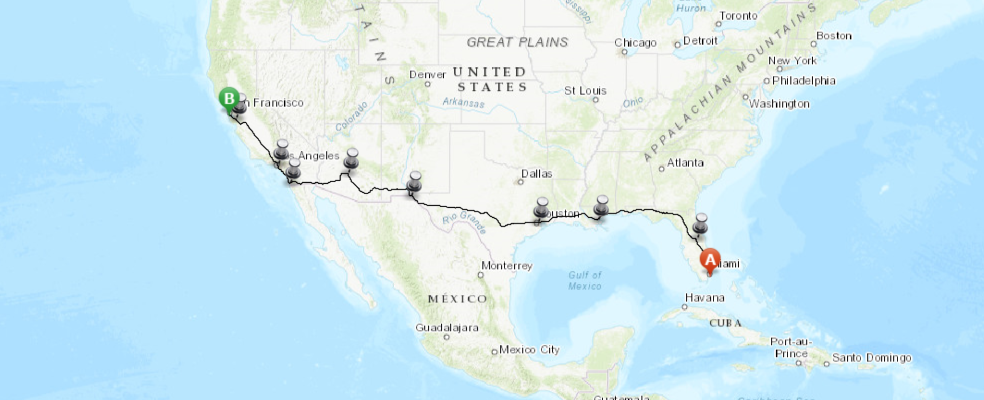

In [29]:
map0 = my_gis.map('Texas, USA', zoomlevel=4)
map0

In [89]:
""" draw the route and stops with customized styles, symbologies, and popups
"""
styles = [    
    dict(selector="td", props=[("padding", "2px")]),
    dict(selector='.row_heading, .blank', props=[('display', 'none;')]),
    dict(selector='.col_heading, .blank', props=[('display', 'none;')])]

route_symbol = {
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                    "color": [128,0,128,90],
                    "width": 4
                }

stops_symbol = {"angle":0,"xoffset":2,"yoffset":8,"type":"esriPMS",
                "url":"http://static.arcgis.com/images/Symbols/Basic/ShinyPin.png",
                "contentType":"image/png","width":24,"height":24}

start_symbol = {"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS",
                "url":"http://static.arcgis.com/images/Symbols/AtoZ/redA.png",
                "contentType":"image/png","width":15.75,"height":21.75}

end_symbol = {"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS",
              "url":"http://static.arcgis.com/images/Symbols/AtoZ/greenB.png",
              "contentType":"image/png","width":15.75,"height":21.75}

popup_route = {"title": "Route", 
               "content": df.style.set_table_styles(styles).render()}
popup_stop = {"title": "Stop {}", 
              "content": df.style.set_table_styles(styles).render()}

In [90]:
map0.draw(result0['routes']['features'][0]['geometry'], popup_route, route_symbol)

Here, we will reuse the function `check_curb_approach` defined in <a href="guide_to_network_analysis_part1.ipynb">Part 1</a> to determine if the stop is the start, the by-passing point, or the end of the route.

In [91]:
 def check_curb_approach(result, stop_id=None):
        if stop_id is not None:
            attributes = result['stops']['features'][stop_id]['attributes']
        else:
            attributes = result['attributes']
        return (attributes['ArriveCurbApproach'], attributes['DepartCurbApproach'])

In [92]:
for stop in result0['stops']['features']:
    
    stop_bool_tuple = check_curb_approach(stop)
    if stop_bool_tuple[0] is None:
        # starting point
        symbol = start_symbol
    elif stop_bool_tuple[1] is None:
        # ending point
        symbol = end_symbol
    else:
        # by-passing point
        symbol = stops_symbol
        
    address = geocoding.reverse_geocode(stop['geometry'])['address']['Match_addr']
    
    map0.draw(stop['geometry'], 
              {"title": "Stop {}".format(stop['attributes']['Sequence']), 
               "content": address},
              symbol)

In [27]:
item_properties = {
    "title": "Miami - San Francisco",
    "tags" : "Routing",
    "snippet": " Route from Miami to San Francisco",
    "description": "a web map of Route from Miami to San Francisco using network.RouteLayer.solve",
    "type": "Feature Collection",
    "typeKeywords": "Data, Feature Collection, Singlelayer",
    "extent" : map0.extent
}

item = map0.save(item_properties)

In [28]:
item

<Item title:"Miami - San Francisco" type:Web Map owner:portaladmin>

### Method 2 - Using arcgis.network.analysis.find_routes

Finding a route analysis can mean determining the quickest or shortest way to travel between locations. You might want to use the `find_routes` tool in arcgis.network.analysis module to generate driving directions to visit multiple stops or to measure the distance or travel time between locations. The tool is capable of finding routes for one or more vehicles each time it runs, so you can determine the best routes for several drivers to visit pre-assigned stops.

Here, set `save_output_na_layer` to True, if you want to save the output route into a new layer file.

In [93]:
%%time
result = network.analysis.find_routes(stops_cities_fset, time_of_day=start_time, 
                                      time_zone_for_time_of_day="UTC",
                                      preserve_terminal_stops="Preserve None",
                                      reorder_stops_to_find_optimal_routes=True,
                                      save_output_na_layer=True)

Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Through Traffic Prohibited").


Wall time: 59.9 s


Compared to the time lapse used in the routing solver of method 1 (47.6 sec), `find_routes` is slower and takes 63 seconds through the cell execution.

Then, let's check if the tool has been successfully run, what are the types of each output element, and the network analysis layer URL of the output route.

In [76]:
result.solve_succeeded

True

In [77]:
result.output_routes, result.output_stops, result.output_directions

(<FeatureSet> 1 features, <FeatureSet> 10 features, <FeatureSet> 281 features)

In [78]:
result.output_network_analysis_layer.url

'https://logistics.arcgis.com/arcgis/rest/directories/arcgisjobs/world/route_gpserver/j1ffa787c7770480b8e400f82b1fa5c9f/scratch/_ags_gpnad09f6128865743c5a50a760e61aaa4eb.lyr'

#### Tabularizing the response from find_routes

In [94]:
""" Access the output directions
"""
df = result.output_directions.sdf
df = df[["RouteName", "ArriveTime", "DriveDistance", "ElapsedTime", "Text"]].loc[df["RouteName"] == "Miami - San Francisco"]
df.head()

,RouteName,ArriveTime,DriveDistance,ElapsedTime,Text
0,Miami - San Francisco,2019-09-27 17:41:31.618000031,0.000000,0.000000,Start at Miami
1,Miami - San Francisco,2019-09-27 17:41:31.618000031,0.089607,0.586174,Go west on SW 13th St toward SW 17th Ave
2,Miami - San Francisco,2019-09-27 17:42:06.788000107,1.043696,2.836031,Turn left on SW 17th Ave
3,Miami - San Francisco,2019-09-27 17:44:55.055000067,0.616441,1.196602,Make a sharp left on S Dixie Hwy (US-1 N)
4,Miami - San Francisco,2019-09-27 17:46:08.746000051,3.317971,7.941983,Keep left at the fork onto I-95 N


In [95]:
df.tail()

,RouteName,ArriveTime,DriveDistance,ElapsedTime,Text
258,Miami - San Francisco,2019-09-29 16:29:56.950999975,0.040609,0.230659,Continue forward on Masonic Ave
259,Miami - San Francisco,2019-09-29 16:30:10.789999962,0.059725,0.417050,Make a sharp right on Upper Ter
260,Miami - San Francisco,2019-09-29 16:30:35.812999964,0.067130,0.586359,Bear left
261,Miami - San Francisco,2019-09-29 16:30:35.812999964,0.000000,0.000000,Restriction: Through Traffic Prohibited
262,Miami - San Francisco,2019-09-29 16:31:10.994999886,0.000000,0.000000,"Finish at San Francisco, on the left"


In [96]:
""" Access output routes
"""
df = result.output_routes.sdf
start_times = pd.to_datetime(df["StartTime"], unit="ms")
end_times = pd.to_datetime(df["EndTime"], unit="ms")
df["StartTime"] = start_times.apply(lambda x: x.strftime("%H:%M:%S"))
df["EndTime"] = end_times.apply(lambda x: x.strftime("%H:%M:%S"))
df[["Name", "StartTime", "EndTime", "StopCount", "Total_Kilometers", "Total_Minutes"]]

,Name,StartTime,EndTime,StopCount,Total_Kilometers,Total_Minutes
0,Miami - San Francisco,17:41:31,16:31:10,10,5265.500512,2989.65628


Based on the results shown above, the estimated travel time from Miami to San Francisco is around 51.01 hours, which means that, if you start from Miami at 20:30 PM (EST) on Monday, for instance, you can expect to arrive at San Francisco at 20:30:49 PM (PST) of the same Wednesday.

#### Visualizing the response from find_routes


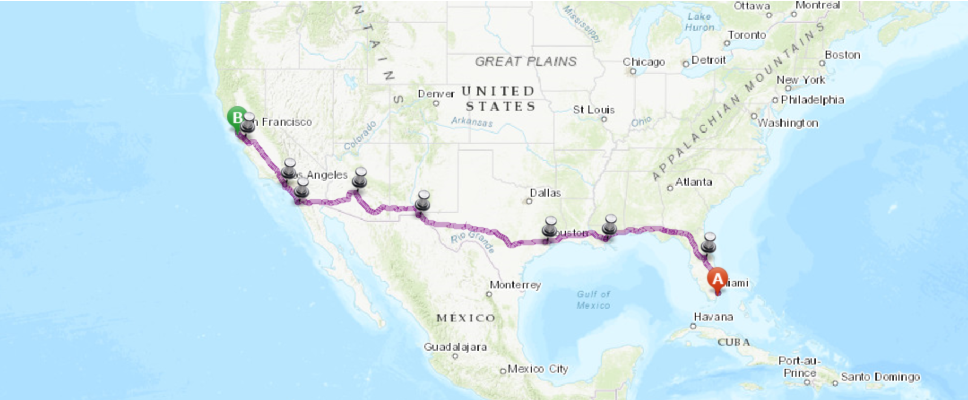

In [62]:
map1 = my_gis.map('Texas, USA', zoomlevel=4)
map1

In [41]:
def check_curb_approach2(result):
        attributes = result.attributes
        return (attributes['ArriveCurbApproach'], attributes['DepartCurbApproach'])

In [42]:
""" draw the route and stops with customized styles, symbologies, and popups
"""
for route in result.output_routes:
    map1.draw(route.geometry, popup_route, route_symbol)

sequence = 1
for stop in result.output_stops:
    
    stop_bool_tuple = check_curb_approach2(stop)
    if stop_bool_tuple[0] is None:
        # starting point
        symbol = start_symbol
    elif stop_bool_tuple[1] is None:
        # ending point
        symbol = end_symbol
    else:
        # by-passing point
        symbol = stops_symbol
        
    address = geocoding.reverse_geocode(stop.geometry)['address']['Match_addr']
    map1.draw(stop.geometry, 
              {"title": "Stop {}".format(sequence), 
               "content": address},
              symbol)
    sequence+=1

In [43]:
item_properties["title"] = "Miami - San Francisco (2)"
item_properties["extent"] = map1.extent
item = map1.save(item_properties)

In [44]:
item

<Item title:"Miami - San Francisco (2)" type:Web Map owner:portaladmin>

#### Comparing method 2's find_routes to method 1's RouteLayer.solve

The `find_routes` and `RouteLayer.solve` tools are similar, but they are designed for different purposes. Use `find_routes` if you want to set up or call via a geoprocessing service; it simplifies the setup and invoking process. Otherwise, `RouteLayer.solve`.

For the former, if there is an existing routing geoprocessing service with the target GIS instance, you can just use it directly. Or else, you will need to create the gp service in the beginning. To create a routing geoprocessing service (which supports `find_routes`), you only need to set up one tool, and you can publish the tool directly as a service. 

In contrast, if a Route Service or Network Analysis endpoint is not yet existent on your current GIS instance, you need to publish the Network Dataset as Map Service with Network Analysis extension turned on first to your Enterprise for ArcGIS. One other option to consider is the ArcGIS Online Find Routes service. It is a service that runs like a geoprocessing tool within ArcMap, can be accessed from other applications, and includes high quality road data for much of the world <a href="#References">[3]</a>.

### Method 3 - Using arcgis.features.use_proximity.plan_routes

In [19]:
stops_cities_fc = FeatureCollection.from_featureset(stops_cities_fset)
start_cities_fc = FeatureCollection.from_featureset(start_cities_fset)

In [20]:
re_ordered_values = "'Miami', 'Orlando','New Orleans', 'Houston','El Paso','Phoenix','San Diego','Los Angeles', 'San Jose', 'San Francisco'"

In [21]:
stops_layer = {'url': sample_cities.layers[0].url, 
               'filter': "ST in ('CA', 'NV', 'TX', 'AZ', 'LA', 'FL')  AND NAME IN ({0})".format(re_ordered_values)}
start_layer = {'url': sample_cities.layers[0].url, 
               'filter': "ST = 'FL' AND NAME = 'Miami'"}
end_layer = {'url': sample_cities.layers[0].url, 
             'filter': "NAME = 'San Francisco'"}

In [22]:
use_proximity.plan_routes??

#### With output_name specified

A reference to the output Feature Layer Collection is returned with `output_name` is specified:

In [26]:
%%time

""" using https://analysis7.arcgis.com/arcgis/rest/services/tasks/GPServer/PlanRoutes/submitJob
"""
result1 = use_proximity.plan_routes(stops_layer=stops_layer, route_count=1, 
                                   max_stops_per_route=10, route_start_time=start_time,
                                   start_layer_route_id_field = "FID",
                                   start_layer=start_layer, 
                                   end_layer=end_layer,
                                   return_to_start=False,
                                   context={'outSR': {"wkid": 4326}},
                                   output_name="Route from Miami to San Francisco",
                                   gis=my_gis)

Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Through Traffic Prohibited").


Wall time: 1min 53s


In [56]:
result1

<Item title:"Route from Miami to San Francisco" type:Feature Layer Collection owner:arcgis_python>

In [57]:
route_sublayer = FeatureLayer.fromitem(result1, layer_id=1)
route_sublayer.url

'https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Route from Miami to San Francisco/FeatureServer/1'

In [58]:
route_sublayer.query(where='1=1', as_df=True)

,EndTime,EndTimeUTC,OBJECTID,RouteLayerItemID,RouteLayerItemURL,RouteName,SHAPE,StartTime,StartTimeUTC,StopCount,TotalStopServiceTime,TotalTime,TotalTravelTime,Total_Kilometers,Total_Miles
0,2019-09-29 19:03:55,2019-09-30 02:03:55,1,None,None,Miami - San Francisco - Route1,"{'paths': [[[-8930153.5818, 2969499.7754], [-8...",2019-09-27 18:25:37,2019-09-27 22:25:37,10,0,3098.295145,3098.295145,5283.613962,3283.093667


In [59]:
solution_route_layer = FeatureLayer(result1.layers[1])
solution_route_layer.url

<FeatureLayer url:"https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Route from Miami to San Francisco/FeatureServer/1">

In [60]:
type(route_sublayer), type(solution_route_layer)

(arcgis.features.layer.FeatureLayer, arcgis.features.layer.FeatureLayer)

In [61]:
solution_route_layer.query(where='1=1', as_df=True)

TypeError: unsupported operand type(s) for +: 'FeatureLayer' and 'str'

In [29]:
map2a = my_gis.map('Texas, USA', zoomlevel=4)
map2a

MapView(layout=Layout(height='400px', width='100%'), zoom=4.0)

In [30]:
map2a.add_layer(fs_item)

Compared to the time lapse used in the routing solver of method 1 (47.6 sec), `find_routes` (62 seconds), the `plan_routes` works much slower, and takes 115 seconds through the cell execution.

#### Without output_name specified

A dict object is returned without `output_name` being specified:

In [63]:
%%time

""" using https://analysis7.arcgis.com/arcgis/rest/services/tasks/GPServer/PlanRoutes/submitJob
"""
result1 = use_proximity.plan_routes(stops_layer=stops_layer, route_count=1, 
                                   max_stops_per_route=10, route_start_time=start_time,
                                   start_layer_route_id_field = "FID",
                                   start_layer=start_layer, 
                                   end_layer=end_layer,
                                   return_to_start=False,
                                   context={'outSR': {"wkid": 4326}},
                                   gis=my_gis)

Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Through Traffic Prohibited").


Wall time: 1min 27s


In [65]:
type(result1), result1.keys()

(dict, dict_keys(['routes_layer', 'assigned_stops_layer']))

In [51]:
df = pd.DataFrame.from_records([i['attributes'] for i in 
                                result1['routes_layer'].layer.featureSet.features])
df[['RouteName', 'StopCount', 'TotalTime', 'Total_Kilometers']]

,RouteName,StopCount,TotalTime,Total_Kilometers
0,Miami - San Francisco - Route1,10,3098.295145,5283.613962


In [52]:
df2 = pd.DataFrame.from_records([i['attributes'] for i in 
                                result1['assigned_stops_layer'].layer.featureSet.features])

df2[['OID', 'NAME', 'ST', 'PLACEFIPS', 'RouteName', 'StopType', 'Sequence', 'ArriveTime', 'FromPrevDistanceKilometers']]

,OID,NAME,ST,PLACEFIPS,RouteName,StopType,Sequence,ArriveTime,FromPrevDistanceKilometers
0,1,None,None,None,Miami - San Francisco - Route1,Route start,1,1568852990000,0.000000
1,2,Miami,FL,1245000,Miami - San Francisco - Route1,Stop,2,1568852990000,0.000000
2,3,Orlando,FL,1253000,Miami - San Francisco - Route1,Stop,3,1568867320816,387.207113
3,4,New Orleans,LA,2255000,Miami - San Francisco - Route1,Stop,4,1568897735273,1028.402021
4,5,Houston,TX,4835000,Miami - San Francisco - Route1,Stop,5,1568917867632,560.582355
5,6,El Paso,TX,4824000,Miami - San Francisco - Route1,Stop,6,1568953298074,1203.096279
6,7,Phoenix,AZ,0455000,Miami - San Francisco - Route1,Stop,7,1568972789729,691.782217
7,8,San Diego,CA,0666000,Miami - San Francisco - Route1,Stop,8,1568993223041,570.860055
8,9,Los Angeles,CA,0644000,Miami - San Francisco - Route1,Stop,9,1569002946278,206.464746
9,10,San Jose,CA,0668000,Miami - San Francisco - Route1,Stop,10,1569023751144,547.928439


In [65]:
my_columns = ['OID', 'NAME', 'ST', 'PLACEFIPS', 'RouteName', 'StopType', 'Sequence', 'ArriveTime', 'FromPrevDistanceKilometers']
length = len(result1['assigned_stops_layer'].layer.featureSet.features)
frames = []
my_df = None

for i in range(length):
    my_list = [result1['assigned_stops_layer'].layer.featureSet.features[i]['attributes'][x] for x in my_columns]
    df = pd.DataFrame(np.array(my_list).reshape(1,9), columns = my_columns)

    end_times = pd.to_datetime(my_list[7], unit="ms")
    df["ArriveTime"] = end_times.strftime("%H:%M:%S")
    df['Sequence'] = int(df['Sequence'])
    if my_df is None:
        my_df=df
    else:
        my_df = my_df.append(df, ignore_index=True, sort=True)

my_df.sort_values('Sequence', inplace=True, ascending=True)
my_df.head(10)

,ArriveTime,FromPrevDistanceKilometers,NAME,OID,PLACEFIPS,RouteName,ST,Sequence,StopType
0,00:29:50,0,None,1,None,Miami - San Francisco - Route1,None,1,Route start
1,00:29:50,0,Miami,2,1245000,Miami - San Francisco - Route1,FL,2,Stop
2,04:28:40,387.20711328584133,Orlando,3,1253000,Miami - San Francisco - Route1,FL,3,Stop
3,12:55:35,1028.402020844327,New Orleans,4,2255000,Miami - San Francisco - Route1,LA,4,Stop
4,18:31:07,560.5823553235924,Houston,5,4835000,Miami - San Francisco - Route1,TX,5,Stop
5,04:21:38,1203.0962787092237,El Paso,6,4824000,Miami - San Francisco - Route1,TX,6,Stop
6,09:46:29,691.7822167745693,Phoenix,7,0455000,Miami - San Francisco - Route1,AZ,7,Stop
7,15:27:03,570.8600546798006,San Diego,8,0666000,Miami - San Francisco - Route1,CA,8,Stop
8,18:09:06,206.46474638188312,Los Angeles,9,0644000,Miami - San Francisco - Route1,CA,9,Stop
9,23:55:51,547.9284393635664,San Jose,10,0668000,Miami - San Francisco - Route1,CA,10,Stop



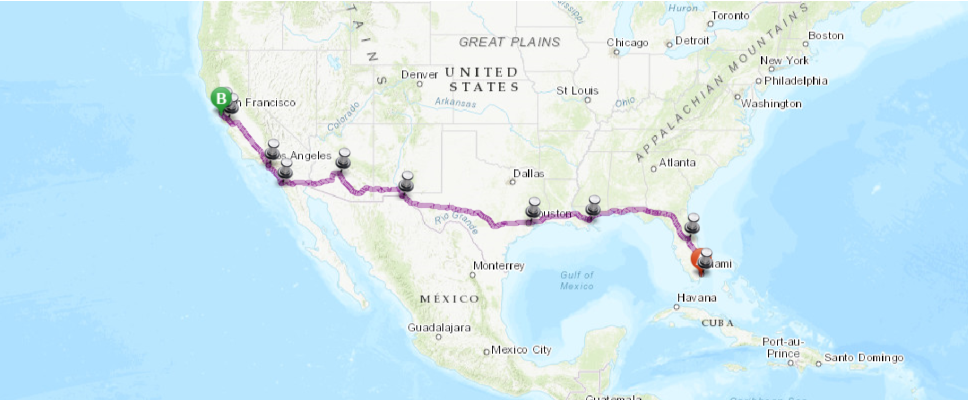

In [61]:
map2 = gis.map('Texas, USA', zoomlevel=4)
map2

In [58]:
""" draw the route and stops with customized styles, symbologies, and popups
"""
for route in result1['routes_layer'].query():
    map2.draw(route.geometry, popup_route, route_symbol)

sequence = 1
for stop in result1['assigned_stops_layer'].query():
    if stop.attributes['StopType']=="Route start":
        # starting point
        symbol = start_symbol
    elif stop.attributes['StopType']=="Route end":
        # ending point
        symbol = end_symbol
    else:
        # by-passing point
        symbol = stops_symbol
        
    address = geocoding.reverse_geocode(stop.geometry)['address']['Match_addr']
    print(address)
    map2.draw(stop.geometry, 
              {"title": "Stop {}".format(sequence), 
               "content": address},
              symbol)
    sequence+=1

1620 SW 13th St, Miami, Florida, 33145
1620 SW 13th St, Miami, Florida, 33145
East-West Expy, Orlando, Florida, 32801
302-330 Loyola Ave, New Orleans, Louisiana, 70112
Starbucks
Anny Fashions
124 S Central Ave, Phoenix, Arizona, 85004
Pershing Dr, San Diego, California, 92101
1523 Cambria St, Los Angeles, California, 90017
61 N 6th St, San Jose, California, 95112
550-560 Buena Vista Ave W, San Francisco, California, 94117
550-560 Buena Vista Ave W, San Francisco, California, 94117


In [59]:
item_properties["title"] = "Miami - San Francisco (3)"
item_properties["extent"] = map2.extent
item = map2.save(item_properties)

In [60]:
item

<Item title:"Miami - San Francisco (3)" type:Web Map owner:portaladmin>

# References

[1] https://pro.arcgis.com/en/pro-app/help/analysis/networks/route-tutorial.htm

[2] https://pro.arcgis.com/en/pro-app/help/analysis/networks/route-analysis-layer.htm

[3] http://desktop.arcgis.com/en/arcmap/10.3/tools/network-analyst-toolbox/find-routes.htm